In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import torch.optim as optim
import copy
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())
torch.set_default_device('cuda:0')

True


In [2]:
# trial data
data = np.load('./data/sample_photostim_0113.npy', allow_pickle = True).item()
#data = np.load('./data/photostim_0404/photostim_0404_date_070623.npy', allow_pickle=True).item()
y = data['y']
u = data['u']
num_trials = y.shape[0]
num_steps = y.shape[1]
num_neurons = y.shape[2]
T_before = 4
T_after_start = 9
T_after_end = 13
y_before = np.mean(y[:,:T_before,:],axis = 1)
y_after = np.mean(y[:,T_after_start:T_after_end,:],axis = 1)

y_session = data['y_session']
u_session = data['u_session']

y_before = data['y_before'] / 1000
y_after = data['y_after'] / 1000
u = data['u']
d = 663

print(y_before.shape)

#linear interpolation of data
y_session_interp = y_session.copy()
for i in range(y_session.shape[1]):
    nan_start = -1
    nan_stop = -1
    for j in range(y_session.shape[0]):
        if nan_start == -1 and np.isnan(y_session_interp[j,i]):
            nan_start = j - 1
        if nan_start != -1 and not np.isnan(y_session_interp[j,i]):
            nan_stop = j
        if nan_start != -1 and nan_stop != -1:
            slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
            for k in range(nan_stop - nan_start - 1):
                y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
            nan_start = -1
            nan_stop = -1
            
print(y_session_interp.shape)
V,_,_ = la.svd(y_session_interp[10:,:].T @ y_session_interp[10:,:] / 10000000)
y_pc1 = V[0,:]

(2308, 663)
(33698, 663)


In [58]:
y_ses_nan = np.isnan(y_session)
y_ses_nan_sum = np.sum(y_ses_nan, axis=1)
y_ses_nan_sum = (y_ses_nan_sum > 0)
print(y_ses_nan_sum.sum())

6927


In [216]:
data = np.load('./data/photostim_0404/photostim_0404_date_070623.npy', allow_pickle=True).item()

y_session = data['y_session']
u_session = data['u_session']
print(u_session.shape)
u_indices = []
for i in range(u_session.shape[0]):
    if np.sum(u_session[i,:]) > 0:
        if (i-1 not in u_indices) and (i-2 not in u_indices):
            u_indices.append(i)

y_before = []
y_after = []
u = []
for i in range(len(u_indices)):
    if i > 0:
        t_start = u_indices[i] - 3
        t_stop = u_indices[i]
        y_before.append(np.mean(y_session[t_start:t_stop,:],axis=0))
        u.append(u_session[t_stop,:])
        
        t_start = u_indices[i] + 3
        if i < len(u_indices) - 1:
            t_stop = u_indices[i+1] - 3
        y_after.append(np.mean(y_session[t_start:t_stop,:],axis=0))
y_before = np.array(y_before[:-1]) / 1000
y_after = np.array(y_after[:-1]) / 1000
u = np.array(u[:-1])
d = 633

print(np.sum(np.isnan(y_before.flatten())))
print(np.sum(np.isnan(y_after.flatten())))
print(y_before.shape,y_after.shape,u.shape)

(29570, 633)
0
0
(2052, 633) (2052, 633) (2052, 633)


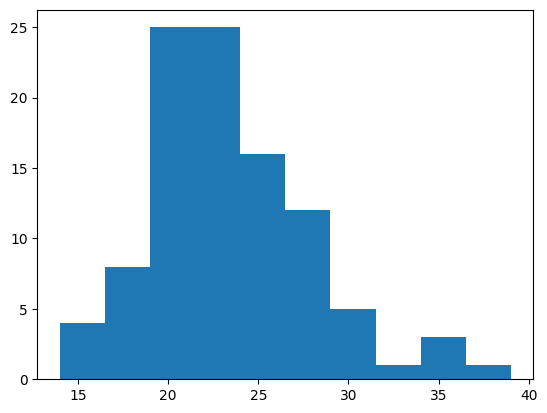

In [3]:
patterns = []
pattern_count = []
pattern_idx = []
pattern_length = []

start = -10
for t in range(u_session.shape[0]):
    if np.sum(np.abs(u_session[t,:])) > 0 and t > start + 4:
        idx = np.linspace(0,663-1,663).astype(int)
        on = u_session[t,:] > 0
        pattern = np.array(idx[on])
        start = t
        found = False
        for i in range(len(patterns)):
            if len(pattern) == len(patterns[i]):
                if np.linalg.norm(pattern - patterns[i]) == 0:
                    pattern_count[i] += 1
                    pattern_idx[i].append(t)
                    found = True
                    break
        if found is False:
            patterns.append(pattern)
            pattern_count.append(1)
            pattern_idx.append([t])
            pattern_length.append(len(pattern))

neuron_pattern = np.zeros(663)
for i in range(663):
    for p in patterns:
        if i in p:
            neuron_pattern[i] += 1

plt.hist(pattern_count)
plt.show()

468 0.20674817496587333
20


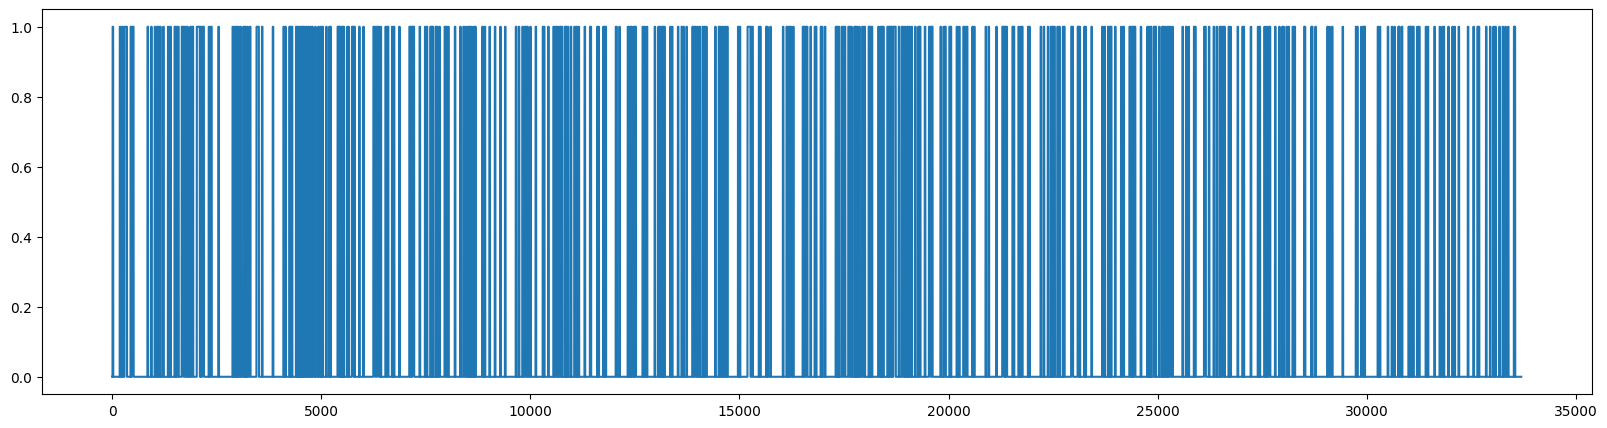

In [10]:
# remove patterns randomly

num_patterns = 20
removed_patterns = []
removed_neurons = []
removed_steps = np.zeros(u_session.shape[0])
removed_count = 0
removed_steps2 = np.zeros(u_session.shape[0])

#removed_patterns = [44, 50, 15, 64, 23]

while len(removed_patterns) < num_patterns:
#for p_idx in removed_patterns:
    p_idx = np.random.randint(0,len(patterns))
    if p_idx not in removed_patterns:
    #if True:
        removed_patterns.append(p_idx)
        removed_count += pattern_count[p_idx]
        removed_neurons.extend(patterns[p_idx])
        for i in pattern_idx[p_idx]:
            min_idx = np.max([0,i-20])
            max_idx = np.min([i+50,u_session.shape[0]-1])
            removed_steps[min_idx:max_idx] = 1
            
            min_idx = np.max([0,i-5])
            max_idx = np.min([i+10,u_session.shape[0]-1])
            removed_steps2[min_idx:max_idx] = 1
            
                
print(removed_count, np.sum(removed_steps2) / u_session.shape[0])
print(len(removed_patterns))
plt.figure(figsize=(20,5))
plt.plot(removed_steps2)
plt.show()

test_indices = removed_steps.astype(int)
test_indices = removed_steps2.astype(int)
train_indices = np.ones(test_indices.shape[0]).astype(int) - test_indices.copy()
removed_neurons = list(set(removed_neurons))

train_test_split = {}
train_test_split['train_indices'] = train_indices
train_test_split['test_indices'] = test_indices
# np.save('train_test_split',train_test_split)

In [28]:
train_segments_y = []
train_segments_u = []
train_u = []
t = 0
saved_indices = np.zeros(train_indices.shape)
while True:
    if np.sum(u_session[t,:]) > 0 and np.sum(u_session[t-1,:]) == 0:
        segment_start = np.max([t - 3, 0])
        segment_stop = np.min([t+12, len(train_indices)])
        if train_indices[segment_start:segment_stop].sum() == len(train_indices[segment_start:segment_stop]):
            segment_y = y_session_interp[segment_start:segment_stop,:].copy()
            segment_u = u_session[segment_start:segment_stop,:].copy()
            if segment_u.shape[0] == 15:
                train_segments_y.append(segment_y / 1000)
                train_segments_u.append(segment_u)
                train_u.append(u_session[t,:])
            saved_indices[segment_start:segment_stop] = 1.0
        t += 10
    else:
        t += 1
    if t >= len(train_indices):
        break
train_u = np.array(train_u)
print(len(train_segments_y), train_u.shape)
print(np.logical_and(saved_indices,train_indices).sum(),np.logical_xor(saved_indices,train_indices).sum(),np.logical_and(saved_indices,test_indices).sum())

1466 (1466, 663)
21342 5389 0


In [57]:
segments_y = []
segments_u = []
t = 0
saved_t = 0
saved_idx = np.zeros(u_session.shape[0])
while True:
    #if np.sum(u_session[t,:]) > 0 and np.sum(u_session[t-1,:]) == 0 and t < saved_t + 5:
    t2 = 5
    while True:
        if np.sum(u_session[saved_t+t2,:]) > 0 and np.sum(u_session[saved_t+t2-1,:]) == 0:
            break
        t2 += 1
        if saved_t+t2 == u_session.shape[0] - 1:
            break
    segment_stop = np.min([saved_t+t2-3, u_session.shape[0]])
    seg_y = y_session_interp[saved_t:segment_stop,:].copy()
    seg_u = u_session[saved_t:segment_stop,:].copy()
    saved_idx[saved_t:segment_stop] += 1.0
    segments_y.append(seg_y)
    segments_u.append(seg_u)
    saved_t = segment_stop
    if saved_t + 5 >= u_session.shape[0]:
        break
print(saved_idx.sum(),u_session.shape[0],np.sum(saved_idx > 1),len(segments_u))

patterns = []
pattern_count = []
pattern_idx = []
pattern_length = []

for i in range(len(segments_u)):
    found_pat = False
    for t in range(segments_u[i].shape[0]):
        if np.sum(np.abs(segments_u[i][t,:])) > 0:
            idx = np.linspace(0,663-1,663).astype(int)
            on = segments_u[i][t,:] > 0
            pattern = np.array(idx[on])
            found = False
            for j in range(len(patterns)):
                if len(pattern) == len(patterns[j]):
                    if np.linalg.norm(pattern - patterns[j]) == 0:
                        pattern_count[j] += 1
                        pattern_idx[j].append(i)
                        found = True
                        break
            if found is False:
                patterns.append(pattern)
                pattern_count.append(1)
                pattern_idx.append([i])
                pattern_length.append(len(pattern))
            found_pat = True
            break
    if not found_pat:
        print('error',i,segments_u[i].sum())

            
# remove patterns randomly

num_patterns = 20
removed_patterns = []
removed_count = 0
train_idx = np.ones(len(segments_u)).astype(int)
test_idx = np.zeros(len(segments_u)).astype(int)

while len(removed_patterns) < num_patterns:
    p_idx = np.random.randint(0,len(patterns))
    if p_idx not in removed_patterns:
        removed_patterns.append(p_idx)
        removed_count += pattern_count[p_idx]
        test_idx[pattern_idx[p_idx]] = 1
        train_idx[pattern_idx[p_idx]] = 0
        
print(removed_count / len(segments_u), test_idx.sum()/len(segments_u))


33694.0 33698 0 2309
0.1974880900822867 0.1974880900822867


In [9]:
spiking = np.zeros(u_session.shape).astype(bool)

for neuron in range(u_session.shape[1]):
    output_true = y_session_interp[4:,neuron]
    mean_threshold = np.median(output_true)
    lower_tail_idx = (output_true < mean_threshold)
    lower_tail_data = output_true[lower_tail_idx]
    lower_tail_std = np.std(lower_tail_data)
    true_spike_threshold = mean_threshold + 6*lower_tail_std
    true_spikes = (output_true > true_spike_threshold)
    spiking[4:,neuron] = true_spikes  

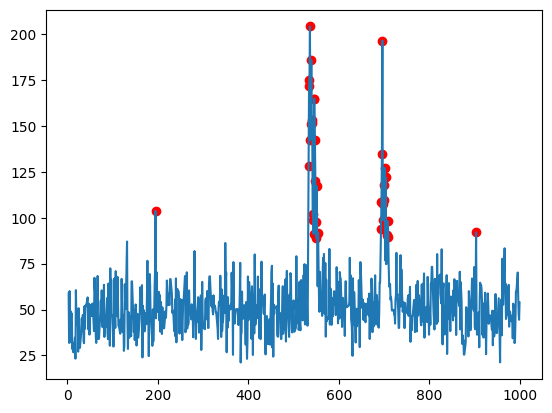

In [10]:
neuron = 206
T = 1000
plt.plot(y_session_interp[:T,neuron])
idx = np.linspace(0,T-1,T)
spiking_neuron = spiking[:T,neuron]
y_out = y_session_interp[0:T,neuron].copy()
y_out = y_out * spiking_neuron
y_out[y_out == 0] = np.nan
plt.scatter(idx,y_out,color='r')  
plt.show()

In [267]:
ark_order = 1
X = []
Xp = []
for t in range(train_indices.shape[0]-ark_order):
    if np.sum(train_indices[t:t+ark_order+1]) == ark_order + 1 and t > 5 + ark_order:
        X.append(np.concatenate((y_session_interp[t:t+ark_order,:].copy().flatten() / 1000, u_session[t:t+ark_order,:].copy().flatten(),np.ones(1)))) 
        Xp.append(y_session_interp[t+ark_order,:].copy().flatten() / 1000)
#     if len(X) > 1472:
#         break
X = np.array(X)
Xp = np.array(Xp)
Ahat = np.linalg.pinv(X.T @ X) @ X.T @ Xp
Ahat = Ahat.T
#np.save('ARk5_gt', Ahat)

B_gt = Ahat[:,d:2*d].copy()
_,S,_ = la.svd(Ahat[:,d:2*d])
print(S.sum())
print(evaluate(Ahat, 1, roc=False))

7.435850589726637
(0.43271330885566917, 0.0011759755948749049)


9.642507287850858
ls (0.47838568770375045, 0.0015217052418456576)


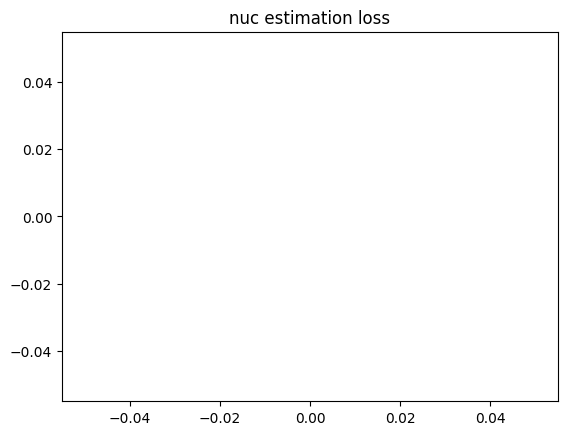

nuc 5 (0.5225757134825401, 0.0015313211488180694)


In [295]:
import importlib
import estimation_procedures as est
importlib.reload(est)

ark_order = 1
X = []
Xp = []
X2 = []
for t in range(train_indices.shape[0]-ark_order):
    if np.sum(train_indices[t:t+ark_order+1]) == ark_order + 1 and t > 5 + ark_order:
        X.append(np.concatenate((u_session[t:t+ark_order,:].copy().flatten(), y_session_interp[t:t+ark_order,:].copy().flatten() / 1000))) 
        X2.append(np.concatenate((u_session[t:t+ark_order,:].copy().flatten(), y_session_interp[t:t+ark_order,:].copy().flatten() / 1000, np.ones(1)))) 
        Xp.append(y_session_interp[t+ark_order,:].copy().flatten() / 1000)
    if len(X) > 4500:
        break
X = np.array(X)
X2 = np.array(X2)
Xp = np.array(Xp)
A_ls = np.linalg.pinv(X2.T @ X2) @ X2.T @ Xp
A_ls = A_ls.T

_,S,_ = la.svd(A_ls[:,0:d])
A_ls2 = A_ls.copy()
A_ls2[:,0:d] = A_ls2[:,d:2*d]
A_ls2[:,d:2*d] = A_ls[:,0:d]
print(S.sum())
print('ls', evaluate(A_ls2, 1, roc=False))

nuc_reg = [5]
nuc_reg = [5]
A_est = []
for reg in nuc_reg:
    A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(X,Xp,reg=reg,transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=0,lr=0.1)
    #A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(X,Xp,reg=reg,n_iters=500,lr=0.1)
    #A_nuc,B_nuc,v_nuc = est.estimate_gd_lowrank_AB_offset(X,Xp,rank=reg,transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=100,lr=0.1)
    G_nuc = np.concatenate((A_nuc,B_nuc,v_nuc[:,None]), axis=1)
    A_est.append(G_nuc)
    print('nuc', reg, evaluate(G_nuc, 1, roc=False))

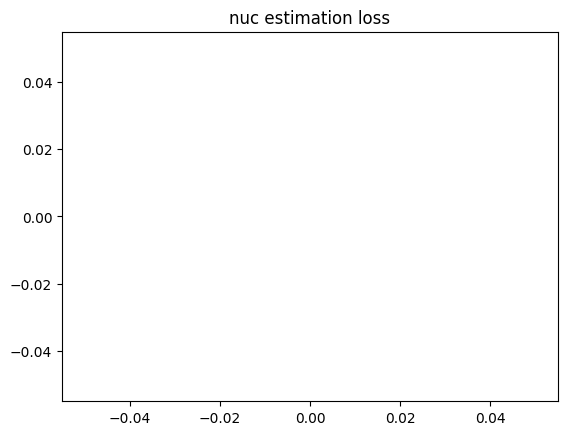

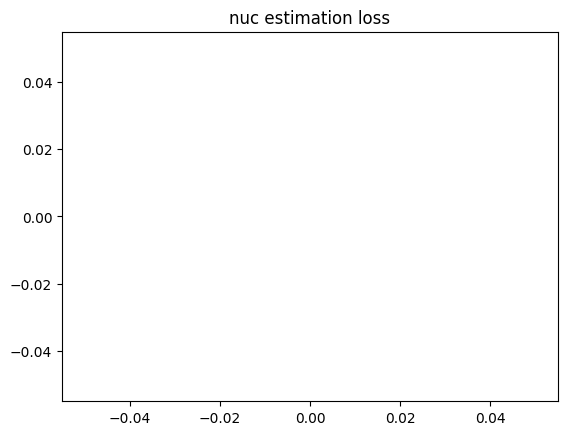

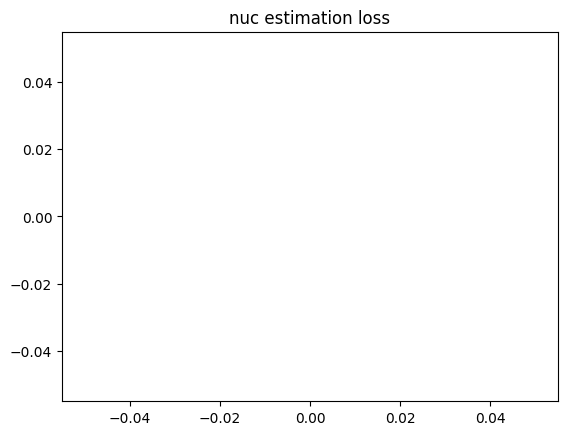

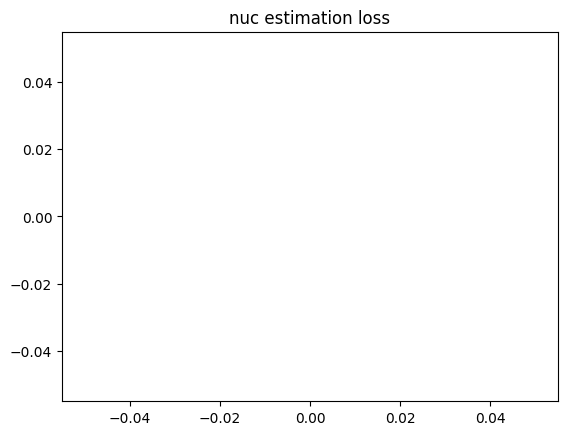

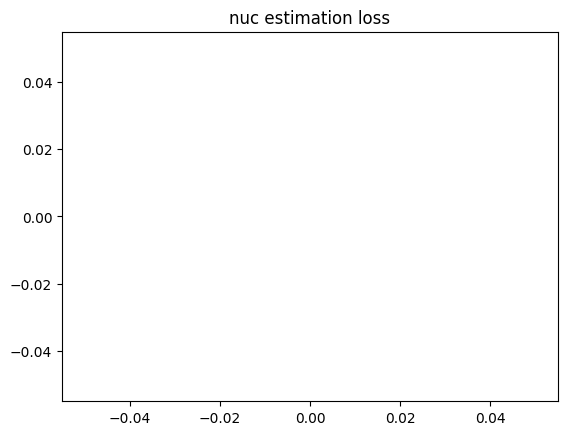

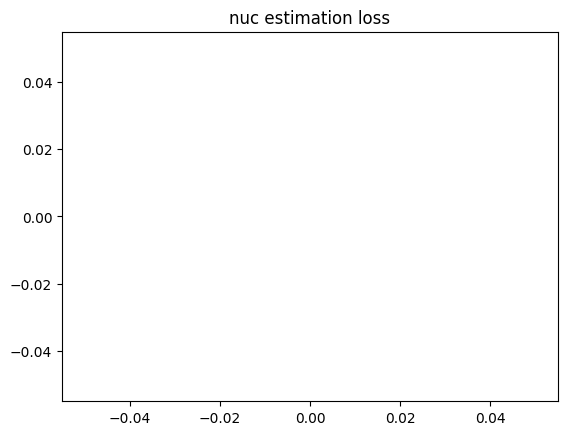

In [285]:
import importlib
import estimation_procedures as est
importlib.reload(est)

e_passive_ls = []
e_passive_nuc = []
e_passive_ls_pc1 = []
e_passive_nuc_pc1 = []
times_passive = []

ark_order = 1
X = []
Xp = []
X2 = []
for t in range(train_indices.shape[0]-ark_order):
    if np.sum(train_indices[t:t+ark_order+1]) == ark_order + 1 and t > 5 + ark_order:
        X.append(np.concatenate((u_session[t:t+ark_order,:].copy().flatten(), y_session_interp[t:t+ark_order,:].copy().flatten() / 1000))) 
        X2.append(np.concatenate((u_session[t:t+ark_order,:].copy().flatten(), y_session_interp[t:t+ark_order,:].copy().flatten() / 1000, np.ones(1)))) 
        Xp.append(y_session_interp[t+ark_order,:].copy().flatten() / 1000)
    if len(X) in times and len(X) > 0:
        Xnp = np.array(X)
        X2np = np.array(X2)
        Xpnp = np.array(Xp)
        A_ls = np.linalg.pinv(X2np.T @ X2np) @ X2np.T @ Xpnp
        A_ls = A_ls.T
        A_ls2 = A_ls.copy()
        A_ls2[:,0:d] = A_ls2[:,d:2*d]
        A_ls2[:,d:2*d] = A_ls[:,0:d]
        A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(Xnp,Xpnp,reg=5,transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=0,lr=0.1)
        G_nuc = np.concatenate((A_nuc,B_nuc,v_nuc[:,None]), axis=1)
        
        times_passive.append(len(X))
        mse,mse_pc1 = evaluate(A_ls2, 1, roc=False)
        e_passive_ls.append(mse)
        e_passive_ls_pc1.append(mse_pc1)
        mse,mse_pc1 = evaluate(G_nuc, 1, roc=False)
        e_passive_nuc.append(mse)
        e_passive_nuc_pc1.append(mse_pc1)

Text(0.5, 1.0, 'mse')

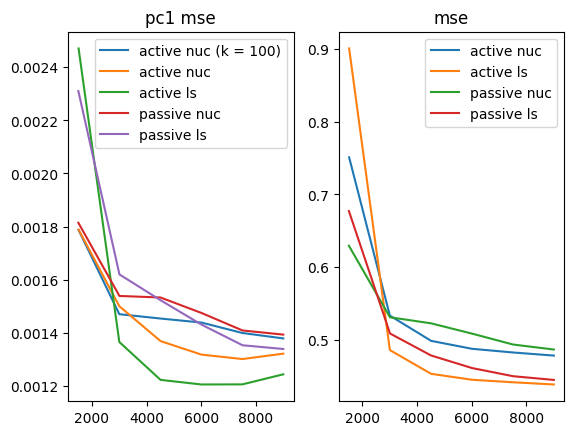

In [292]:
plt.subplot(1,2,1)
plt.plot(times[1:],e_active_nuc_k10[:-1],label='active nuc (k = 100)')
plt.plot(times[1:],e_active_nuc_pc1,label='active nuc')
plt.plot(times[1:], e_active_ls_pc1 ,label='active ls')
plt.plot(times_passive,e_passive_nuc_pc1,label='passive nuc')
plt.plot(times_passive,e_passive_ls_pc1,label='passive ls')
plt.legend()
plt.title('pc1 mse')

plt.subplot(1,2,2)
plt.plot(times[1:],e_active_nuc,label='active nuc')
plt.plot(times[1:], e_active_ls ,label='active ls')
plt.plot(times_passive,e_passive_nuc,label='passive nuc')
plt.plot(times_passive,e_passive_ls,label='passive ls')
plt.legend()
plt.title('mse')

# Active Learning

In [411]:
def run_experiment_helper(params):
    data = {}
    data["time"] = []
    for est_type in params["est_type"]:
        data[est_type + '_mse'] = []
        data[est_type + '_mse_pc1'] = []
        if params["roc"]:
            data[est_type + "_roc"] = []
            data[est_type + "_roc_noin"] = []
    X = []
    X2 = []
    Y = []
    d = params["d"]
    input_cov = 0.000001 * np.eye(d)
    state_cov = 0.000001 * np.eye(d)
    if params["type"] == "oracle":
        _,_,V_true = la.svd(params["B_gt"])
        V_true = V_true[0:params["inputs_r"],:]
    
    available_idx = np.ones(len(train_segments_y)).astype(int)
    N = len(train_segments_y)

    for t in range(params["T"]):
        if params["type"] == "passive":
            query_idx = np.random.choice(range(N), p=available_idx/available_idx.sum())
        elif params["type"] == "sequential":
            query_idx = t
        elif params["type"] == "oracle":
            if np.mod(t,2) > 0:
                input_cov_inv = la.inv(V_true @ input_cov @ V_true.T)
                cov_u = input_cov_inv @ V_true @ train_u.T
                ip = np.sum(cov_u * cov_u, axis=0)
                ip = np.multiply(ip,available_idx)
                ip[np.isnan(ip)] = 0
                query_idx = np.argmax(ip)
            else:
                query_idx = np.random.choice(range(N), p=available_idx/available_idx.sum())
#                 input_cov_inv = la.inv(input_cov)
#                 cov_u = input_cov_inv @ train_u.T
#                 ip = np.sum(cov_u * cov_u, axis=0)
#                 ip = np.multiply(ip,available_idx)
#                 ip[np.isnan(ip)] = 0
#                 query_idx = np.argmax(ip)
#                 state_cov_inv = la.inv(state_cov)
#                 state_cov_inv_sq = state_cov_inv @ state_cov_inv
#                 max_val = -1
#                 max_idx = -1
#                 for i in range(len(available_idx)):
#                     if available_idx[i]:
#                         val = np.trace(train_segments_y[i][0:15,:] @ state_cov_inv_sq @ train_segments_y[i][0:15,:].T)
#                         if val > max_val:
#                             max_val = val
#                             max_idx = i
#                 query_idx = max_idx
        elif params["type"] == "active":
            if np.mod(t,2) > 0 and t > params["record_interval"]:
                input_cov_inv = la.inv(V_hat @ input_cov @ V_hat.T)
                cov_u = input_cov_inv @ V_hat @ train_u.T
                ip = np.sum(cov_u * cov_u, axis=0)
                ip = np.multiply(ip,available_idx)
                ip[np.isnan(ip)] = 0
                query_idx = np.argmax(ip)
            else:
                query_idx = np.random.choice(range(N), p=available_idx/available_idx.sum())
        
        for i in range(15):
            X.append(np.concatenate((train_segments_u[query_idx][i,:].copy().flatten(), train_segments_y[query_idx][i,:].copy().flatten())))
            X2.append(np.concatenate((train_segments_u[query_idx][i,:].copy().flatten(), train_segments_y[query_idx][i,:].copy().flatten(), np.ones(1))))
            Y.append(train_segments_y[query_idx][i+1,:].copy().flatten())
            state_cov += np.outer(train_segments_y[query_idx][i,:].copy().flatten(), train_segments_y[query_idx][i,:].copy().flatten())
        input_cov += np.outer(train_u[query_idx,:], train_u[query_idx,:])
        available_idx[query_idx] = 0
        
        if np.mod(t, params["record_interval"]) == 0 and t > 0:
            print('estimating', t)
            Xnp = np.array(X)
            X2np = np.array(X2)
            Ynp = np.array(Y)
            A_ls = np.linalg.pinv(X2np.T @ X2np) @ X2np.T @ Ynp
            A_ls = A_ls.T
            A_ls_eval = A_ls.copy()
            A_ls_eval[:,0:d] = A_ls_eval[:,d:2*d]
            A_ls_eval[:,d:2*d] = A_ls[:,0:d]
            data["time"].append(t)
            if params["type"] == "active":
                _,_,V_hat = la.svd(A_ls[:,0:d])
                V_hat = V_hat[0:params["inputs_r"],:]
            
            if "ls" in params["est_type"]:
                if params["roc"]:
                    mse, mse_pc1, tpr, fpr, tpr_noin, fpr_noin = evaluate(A_ls_eval, 1)
                    data["ls_roc"].append([fpr,tpr])
                    data["ls_roc_noin"].append([fpr_noin,tpr_noin])
                else:
                    mse, mse_pc1 = evaluate(A_ls_eval, 1, roc=False)
                data["ls_mse"].append(mse)
                data["ls_mse_pc1"].append(mse_pc1)
            if "nuc" in params["est_type"]:
                A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(Xnp,Ynp,reg=params["nuc_reg"],transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=0,lr=0.1)
                G_nuc = np.concatenate((A_nuc,B_nuc,v_nuc[:,None]), axis=1)
                if params["roc"]:
                    mse, mse_pc1, tpr, fpr, tpr_noin, fpr_noin = evaluate(G_nuc, 1)
                    data["nuc_roc"].append([fpr,tpr])
                    data["nuc_roc_noin"].append([fpr_noin,tpr_noin])
                else:
                    mse, mse_pc1 = evaluate(G_nuc, 1, roc=False)
                data["nuc_mse"].append(mse)
                data["nuc_mse_pc1"].append(mse_pc1)
    return data

def run_experiment(params, data=None):
    print('running: ' + params["name"])
    N = params["num_trials"]
    for trial_idx in range(params["num_trials"]):
        print('trial: ' + str(trial_idx))
        if trial_idx == 0 and data is None:
            data = run_experiment_helper(params)
            for name in data.keys():
                if "roc" not in name:
                    data[name] = np.array(data[name]) / N
                else:
                    for i in range(len(data[name])):
                        data[name][i][0] = np.array(data[name][i][0]) / N
                        data[name][i][1] = np.array(data[name][i][1]) / N
        else:
            data_trial = run_experiment_helper(params)
            for name in data_trial.keys():
                if "roc" not in name:
                    data[name] += np.array(data_trial[name]) / N
                else:
                    for i in range(len(data_trial[name])):
                        data[name][i][0] += np.array(data_trial[name][i][0]) / N
                        data[name][i][1] += np.array(data_trial[name][i][1]) / N
    return data

In [412]:
import importlib
import input_design
import estimation_procedures as est
importlib.reload(est)
importlib.reload(input_design)

data = {}
params = {
    "name": "passive",
    "type": "passive",
    "num_trials": 30,
    "B_gt": B_gt,
    "T": 1601,
    "record_interval": 400,
    "est_type": ["ls"],
    "roc": False,
    "d": 663, 
    "nuc_reg": 5,
    "inputs_r": 50, 
}

data_new = run_experiment(params)
data[params["name"]] = data_new


params["name"] = "oracle"
params["type"] = "oracle"
data_new = run_experiment(params)
data[params["name"]] = data_new


# params["name"] = "sequential"
# params["type"] = "sequential"
# params["num_trials"] = 1
# data_new = run_experiment(params)
# data[params["name"]] = data_new


params["name"] = "active"
params["type"] = "active"
data_new = run_experiment(params)
data[params["name"]] = data_new

running: passive
trial: 0
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 1
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 2
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 3
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 4
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 5
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 6
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 7
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 8
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 9
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 10
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 11
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 12
estimating 400
estimating 800
estimating 1200
estimating 1600
trial: 13
estimating 400
estimating 800
estimating 1200
e

In [405]:
name = "passive"
for est_type in data[name].keys():
    data[name][est_type] /= 2

{'passive': {'time': array([ 400.,  800., 1200., 1600.]), 'ls_mse': array([0.45671296, 0.4402561 , 0.43619394, 0.4344883 ]), 'ls_mse_pc1': array([0.0012369 , 0.00119149, 0.00117377, 0.00117242])}, 'oracle': {'time': array([ 400.,  800., 1200., 1600.]), 'ls_mse': array([0.44982685, 0.43661653, 0.43330373, 0.43412632]), 'ls_mse_pc1': array([0.00125998, 0.00117679, 0.00115349, 0.0011677 ])}, 'active': {'time': array([ 400.,  800., 1200., 1600.]), 'ls_mse': array([0.45660661, 0.43609866, 0.4326723 , 0.43399793]), 'ls_mse_pc1': array([0.00123344, 0.00117768, 0.0011584 , 0.00116714])}}


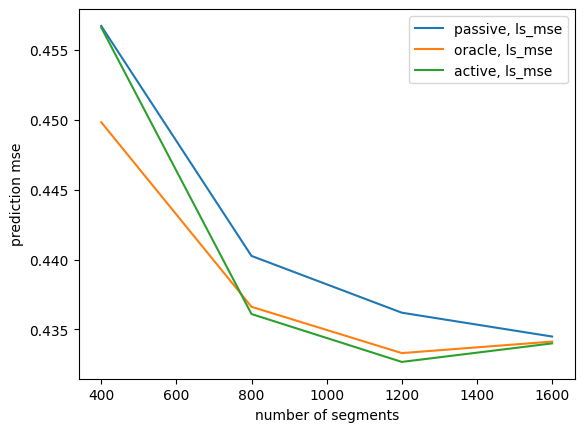

In [414]:
exclude = ['time','input_norm','nuc_mse','nuc_mse_pc1']
#plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
for name in data.keys():
    for est_type in data[name].keys():
        if est_type not in exclude and name not in exclude and "mse" in est_type and "pc1" not in est_type:
            plt.plot(data[name]["time"], data[name][est_type], label=name + ", " + est_type)
plt.ylabel('prediction mse')
plt.xlabel('number of segments')
plt.legend()

# plt.subplot(1,2,2)
# for name in data.keys():
#     for est_type in data[name].keys():
#         if est_type not in exclude and name not in exclude and "mse_pc1" in est_type:
#             plt.plot(data[name]["time"], data[name][est_type], label=name + ", " + est_type)
# plt.ylabel('prediction mse in pc1')
# plt.xlabel('number of segments')
# plt.legend()
# plt.show()

print(data)

In [442]:
import importlib
import input_design
import estimation_procedures as est
import pickle
importlib.reload(est)
importlib.reload(input_design)

data_roc = {}
params = {
    "name": "passive",
    "type": "passive",
    "num_trials": 10,
    "B_gt": B_gt,
    "T": 201,
    "record_interval": 200,
    "est_type": ["ls","nuc"],
    "roc": True,
    "d": 663, 
    "nuc_reg": 5,
    "inputs_r": 50, 
}

data_new = run_experiment(params)
data_roc[params["name"]] = data_new
# with open('./results/real_roc1.pkl', 'wb') as f:
#     pickle.dump(data_roc, f)


# params["name"] = "oracle"
# params["type"] = "oracle"
# data_new = run_experiment(params)
# data_roc[params["name"]] = data_new
# with open('./results/real_roc2.pkl', 'wb') as f:
#     pickle.dump(data_roc, f)


# params["name"] = "active"
# params["type"] = "active"
# data_new = run_experiment(params)
# data_roc[params["name"]] = data_new
# with open('./results/real_roc3.pkl', 'wb') as f:
#     pickle.dump(data_roc, f)


# params["name"] = "oracle-nuc_reg3"
# params["type"] = "oracle"
# params["nuc_reg"] = 3
# data_new = run_experiment(params)
# data_roc[params["name"]] = data_new
# with open('./results/real_roc4.pkl', 'wb') as f:
#     pickle.dump(data_roc, f)


params["name"] = "oracle-nuc_reg7"
params["type"] = "oracle"
params["nuc_reg"] = 7
data_new = run_experiment(params)
data_roc[params["name"]] = data_new
# with open('./results/real_roc5.pkl', 'wb') as f:
#     pickle.dump(data_roc, f)


# params["name"] = "oracle-inputs_r25"
# params["type"] = "oracle"
# params["nuc_reg"] = 5
# params["inputs_r"] = 25
# data_new = run_experiment(params)
# data_roc[params["name"]] = data_new
# with open('./results/real_roc6.pkl', 'wb') as f:
#     pickle.dump(data_roc, f)


# params["name"] = "oracle-inputs_r75"
# params["type"] = "oracle"
# params["inputs_r"] = 75
# data_new = run_experiment(params)
# data_roc[params["name"]] = data_new
with open('./results/real_roc_T200_10trial_best.pkl', 'wb') as f:
    pickle.dump([data_roc,params], f)


# params["name"] = "sequential"
# params["type"] = "sequential"
# params["num_trials"] = 1
# data_new = run_experiment(params)
# data_roc[params["name"]] = data_new
# with open('./results/real_roc8.pkl', 'wb') as f:
#     pickle.dump(data_roc, f)

running: passive
trial: 0
estimating 200
trial: 1
estimating 200
trial: 2
estimating 200
trial: 3
estimating 200
trial: 4
estimating 200
trial: 5
estimating 200
trial: 6
estimating 200
trial: 7
estimating 200
trial: 8
estimating 200
trial: 9
estimating 200
running: oracle-nuc_reg7
trial: 0
estimating 200
trial: 1
estimating 200
trial: 2
estimating 200
trial: 3
estimating 200
trial: 4
estimating 200
trial: 5
estimating 200
trial: 6
estimating 200
trial: 7
estimating 200
trial: 8
estimating 200
trial: 9
estimating 200


passive ls_roc
passive nuc_roc
oracle-nuc_reg7 ls_roc
oracle-nuc_reg7 nuc_roc


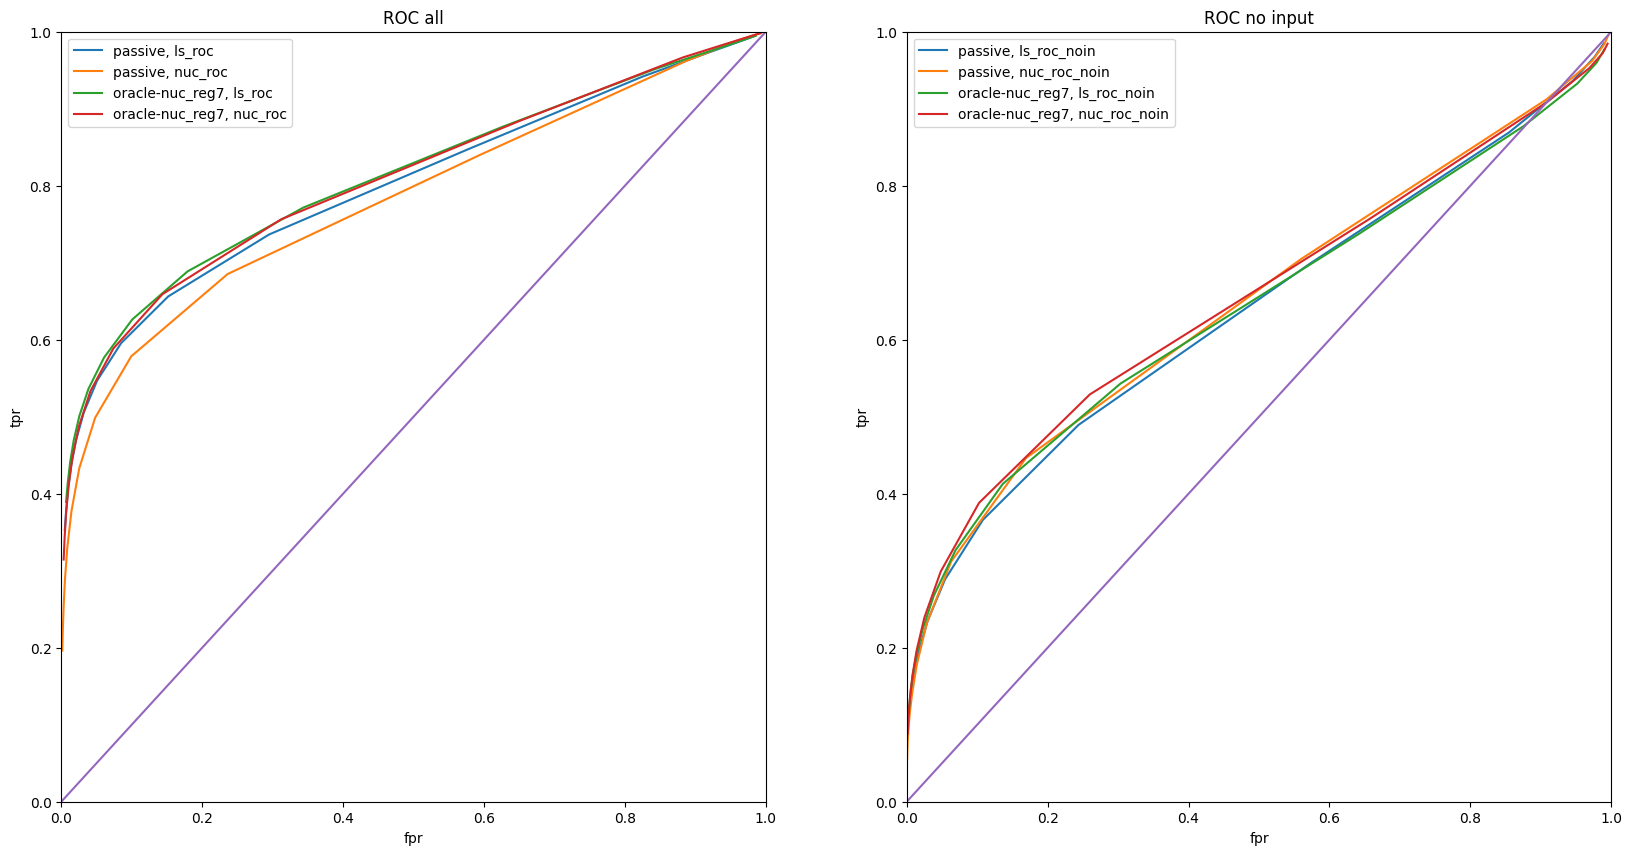

In [443]:
roc_idx = 0
exclude = ['time','input_norm','nuc_mse','nuc_mse_pc1','active','oracle-inputs_r75','oracle-nuc_reg3','oracle-inputs_r25']
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
for name in data_roc.keys():
    for est_type in data_roc[name].keys():
        if est_type not in exclude and name not in exclude and "roc" in est_type and "roc_noin" not in est_type:
            print(name,est_type)
            plt.plot(data_roc[name][est_type][roc_idx][0], data_roc[name][est_type][roc_idx][1], label=name + ", " + est_type)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('ROC all')
plt.legend()

plt.subplot(1,2,2)
for name in data_roc.keys():
    for est_type in data_roc[name].keys():
        if est_type not in exclude and name not in exclude and "roc_noin" in est_type:
            plt.plot(data_roc[name][est_type][roc_idx][0], data_roc[name][est_type][roc_idx][1], label=name + ", " + est_type)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('ROC no input')
plt.legend()
plt.show()

In [441]:
with open('./results/real_roc_T200_1trial_ablation.pkl', 'wb') as f:
    pickle.dump([data_roc,params], f)

# Evaluation functions

In [12]:
def compute_gt_test_segments(y_session,true_spikes,prediction,test_indices,start_idx):
    x_true = []
    u_true = []
    labels = []
    pred_new = []
    input_segment = []
    idx = -1

    new_segment = True
    segment_pred = []
    segment_start = -1
    for t in range(test_indices.shape[0]):
        if test_indices[t] == 1:
            if new_segment:
                pred_idx = 0
                new_segment = False
                segment_start = t
                x_past = []
                x_true.append([])
                u_true.append([])
                labels.append([])
                pred_new.append([])
                input_segment.append(0)
                idx += 1
            if t >= segment_start + start_idx:
                if not np.isnan(y_session[t,0]):
                    x_true[idx].append(y_session[t,:].copy().flatten() / 1000)
                    u_true[idx].append(u_session[t,:].copy().flatten())
                    labels[idx].append(true_spikes[t,:].copy().flatten())
                    pred_new[idx].append(prediction[idx][pred_idx,:].copy().flatten())
                pred_idx += 1
            input_segment[idx] = np.sum(u_session[segment_start:segment_start+t+1,:], axis=0) > 0
        else:
            new_segment = True

    for i in range(len(x_true)):
        x_true[i] = np.array(x_true[i])
        u_true[i] = np.array(u_true[i])
        labels[i] = np.array(labels[i]).astype(bool)
        pred_new[i] = np.array(pred_new[i])
        
    return x_true, u_true, labels, pred_new, input_segment

In [16]:
def compute_roc(prediction,start_idx,thresholds=np.linspace(-2,5,15),train_indices=None,test_indices=None,true_spikes=None):
    '''
    Inputs:
    prediction - Assume there are n distinct test segments, and segment i has length m_i. Then prediction should
    be a list of length n, where element i in the list is the predictions on the indices at test segment i.
    We assume the model may use the first start_idx samples from each test segment to initialize the model, 
    so prediction[i] should be an numpy array of size (m_i - start_idx, 663). 
    
    start_idx - see above.
    
    thresholds - array true/false spike thresholds to classify predictions as spikes.
    
    Outputs: 
    tpr - array of length len(thresholds) of true positive rate for all predictions
    fpr - array of length len(thresholds) of false positive rate for all predictions
    tpr_noinput - array of length len(thresholds) of true positive rate for predictions on neurons where input
                    not applied.
    fpr_noinput - array of length len(thresholds) of false positive rate for predictions on neurons where input
                    not applied.
    '''
    #data = np.load('sample_photostim_0113.npy', allow_pickle = True).item()
    #y_session = data['y_session']
    #u_session = data['u_session']
#     if train_indices is None:
#         split = np.load('../train_test_split.npy', allow_pickle=True).item()
#         train_indices = split['train_indices']
#         test_indices = split['test_indices']
#     true_spikes = np.load('../spiking_labels.npy')
    x_true, u_true, true_spikes, prediction, input_segment = compute_gt_test_segments(y_session,true_spikes,prediction,test_indices,start_idx)
    
    tpr = []
    fpr = []
    tpr_noinput = []
    fpr_noinput = []

    for thresholds_idx in range(len(thresholds)):
        for mode_idx in range(2):
            tp_total = 0
            fp_total = 0
            p_total = 0
            n_total = 0

            for neuron in range(u_session.shape[1]):
                output_pred = []
                output_true = []
                output_label = []
                sequence_idx = 0
                for i in range(len(x_true)):
                    if mode_idx == 0:
                        output_pred.extend(prediction[i][:,neuron])
                        output_true.extend(x_true[i][:,neuron])
                        output_label.extend(true_spikes[i][:,neuron])
                    elif not input_segment[i][neuron]:
                        output_pred.extend(prediction[i][:,neuron])
                        output_true.extend(x_true[i][:,neuron])
                        output_label.extend(true_spikes[i][:,neuron])
                output_pred = np.array(output_pred)
                output_true = np.array(output_true)
                output_label = np.array(output_label).astype(bool)

                mean_threshold = np.median(output_true)
                lower_tail_idx = (output_true < mean_threshold)
                lower_tail_data = output_true[lower_tail_idx]
                lower_tail_std = np.std(lower_tail_data)
                detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

                predicted_spikes = (output_pred > detect_spike_threshold)
                tp_total += np.sum(np.logical_and(predicted_spikes,output_label))
                fp_total += np.sum(np.logical_and(predicted_spikes,~output_label))
                p_total += np.sum(output_label)
                n_total += np.sum(~output_label)

            if mode_idx == 0:
                tpr.append(tp_total / p_total)
                fpr.append(fp_total / n_total)
            else:
                if p_total > 0:
                    tpr_noinput.append(tp_total / p_total)
                if n_total > 0:
                    fpr_noinput.append(fp_total / n_total)
    return tpr, fpr, tpr_noinput, fpr_noinput

In [266]:
def evaluate(Ahat, ark_order, roc=True):
    x_pred = []
    x_true = []
    u_true = []
    mse = 0
    mse_pc1 = 0
    count = 0
    idx = -1
    
    new_segment = True
    segment_pred = []
    segment_start = -1
    for t in range(train_indices.shape[0]):
        if test_indices[t] == 1:
            if new_segment:
                segment_pred = []
                new_segment = False
                segment_start = t
                x_past = []
                x_pred.append([])
                x_true.append([])
                u_true.append([])
                idx += 1
            if t < segment_start + ark_order:
                x_past.append(y_session_interp[t,:].copy().flatten() / 1000)
            else:
                z = np.array(x_past).flatten()
                z = np.concatenate((z,u_session[t-ark_order:t,:].copy().flatten(),np.ones(1)))
                x_next = Ahat @ z
                x_past.pop(0)
                x_past.append(x_next.copy())
                x_pred[idx].append(x_next.copy())
                x_true[idx].append(y_session_interp[t,:].copy().flatten() / 1000)
                u_true[idx].append(u_session[t,:].copy().flatten())
                mse += np.linalg.norm(x_next.copy() - y_session_interp[t,:].copy().flatten() / 1000, 2)**2
                mse_pc1 += (y_pc1.T @ (x_next.copy() - y_session_interp[t,:].copy().flatten() / 1000))**2
                count += 1
        else:
            new_segment = True

    for i in range(len(x_pred)):
        x_pred[i] = np.array(x_pred[i])
        x_true[i] = np.array(x_true[i])
        u_true[i] = np.array(u_true[i])
    
    if roc:
        tpr, fpr, tpr_noin, fpr_noin = compute_roc(x_pred,ark_order,thresholds=np.linspace(-2,5,15),train_indices=train_indices,test_indices=test_indices,true_spikes=spiking)
        return mse / count, mse_pc1 / count, tpr, fpr, tpr_noin, fpr_noin
    else:
        return mse / count, mse_pc1 / count

In [265]:
np.linalg.norm(y_pc1.T @ y_session_interp[10,:].copy().flatten())

27.225723641346153

In [17]:
tpr, fpr, tpr_noin, fpr_noin = compute_roc(x_pred,3,thresholds=np.linspace(-2,5,15),train_indices=train_indices,test_indices=test_indices,true_spikes=spiking)

/home/ajwagen/anaconda3/envs/basic_ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ajwagen/anaconda3/envs/basic_ml/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ajwagen/anaconda3/envs/basic_ml/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ajwagen/anaconda3/envs/basic_ml/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ajwagen/anaconda3/envs/basic_ml/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
Ahat3 = Ahat.copy()

mse ls1  0.4717921476218252
mse nuc 1 0.6079758976095432
mse nuc 3 0.5499072915686948
mse nuc 5 0.511280339549539


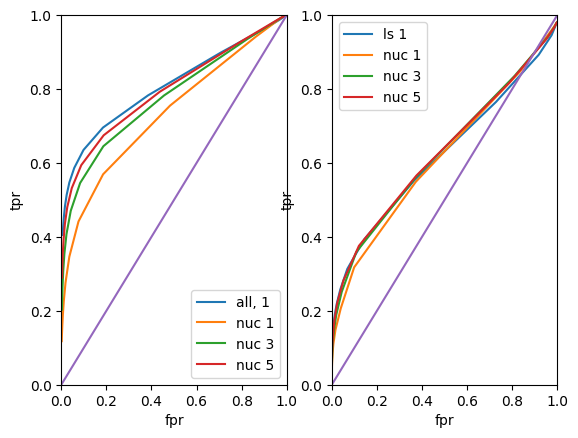

In [59]:
# plt.figure(figsize=(10,5))
# #mse3, tpr3, fpr3, tpr_noin3, fpr_noin3 = evaluate(Ahat3, 3)
# print('mse ls3 ', mse3)
# plt.subplot(1,2,1)
# plt.plot(fpr3,tpr3,label='all, 3')
# plt.subplot(1,2,2)
# plt.plot(fpr_noin3,tpr_noin3,label='ls 3')

mse1, tpr1, fpr1, tpr_noin1, fpr_noin1 = evaluate(Ahat, 1)
print('mse ls1 ', mse1)
plt.subplot(1,2,1)
plt.plot(fpr1,tpr1,label='all, 1')
plt.subplot(1,2,2)
plt.plot(fpr_noin1,tpr_noin1,label='ls 1')

mse_nuc = []
fpr_nuc = []
tpr_nuc = []
tpr_noin_nuc = []
fpr_noin_nuc = []
for i in range(len(nuc_reg)):
    mse, tpr, fpr, tpr_noin, fpr_noin = evaluate(A_est[i], 1)
    mse_nuc.append(mse)
    fpr_nuc.append(fpr)
    tpr_nuc.append(tpr)
    tpr_noin_nuc.append(tpr_noin)
    fpr_noin_nuc.append(fpr_noin)
    print('mse nuc',nuc_reg[i],mse)
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,label='nuc ' + str(nuc_reg[i]))
    plt.subplot(1,2,2)
    plt.plot(fpr_noin,tpr_noin,label='nuc ' + str(nuc_reg[i]))

plt.subplot(1,2,1)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

plt.subplot(1,2,2)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()

# Input optimization

0 637.9260250892911
50 22.710699122560648


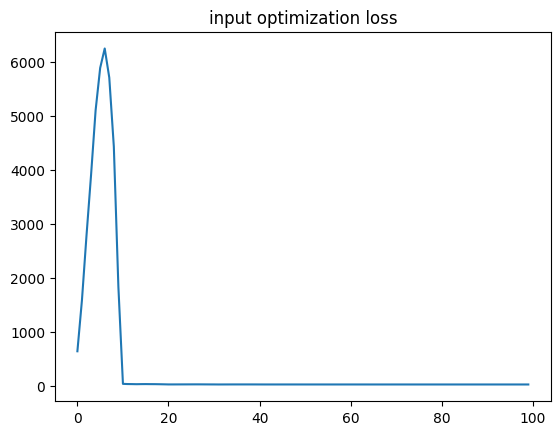

637.9260250892911 22.516690141977687


In [255]:
def design_inputs_fw(transfer_est, 
        verbose=True, 
        n_iters=1000, 
        k=50, 
        num_random=None,
        cov0=None):
    d = transfer_est.shape[0]
    n = available_idx.shape[0]
    inputs_dist = available_idx.copy() / available_idx.sum()
    #inputs_dist[0] = 1.0

    _,_,V_true = la.svd(transfer_est)
    V_true = V_true[0:k,:]
    
    min_inputs = None
    min_loss = 1e10
    loss_vals = []
    A = np.zeros((k,k))
    for i in range(n):
        if available_idx[i]:
            A += np.outer(V_true @ u_session[i,:],V_true @ u_session[i,:]) / n
    
    for iter_idx in range(n_iters):
        max_input = -1
        max_val = 0
        A_inv = la.inv(A + 0.00001 * np.eye(k))
        cov_u = A_inv @ V_true @ u_session.T
        ip = np.sum(cov_u * cov_u, axis=0)
        ip = np.multiply(ip,available_idx)
        max_idx = np.argmax(ip)
        gamma = 2/(iter_idx+3)
        A = (1 - gamma) * A + gamma * np.outer(V_true @ u_session[max_idx,:], V_true @ u_session[max_idx,:])
        new_dist = np.zeros(n)
        new_dist[max_idx] = 1.0
        inputs_dist = (1 - gamma) * inputs_dist + gamma * new_dist
        
        loss = np.trace(A_inv)
        
        if np.mod(iter_idx,50) == 0 and verbose:
            print(iter_idx,loss)
        loss_vals.append(loss)
    #if verbose:
    plt.plot(loss_vals)
    #plt.yscale('log')
    plt.title("input optimization loss")
    plt.show()
    
    print(loss_vals[0],loss_vals[-1])

    return inputs_dist


# U,S,V = torch.linalg.svd(0.1*torch.randn(663,663))
# S[50:0] = 0
# T = U @ torch.diag(S) @ V

# patterns2 = []
# for i in range(700):
#     patterns2.append(torch.randn(663))
T = B_gt.copy()
x = design_inputs_fw(T, n_iters=100, k=10)
#plt.plot(x)
#print(np.max(x),np.min(x),np.sum(x))

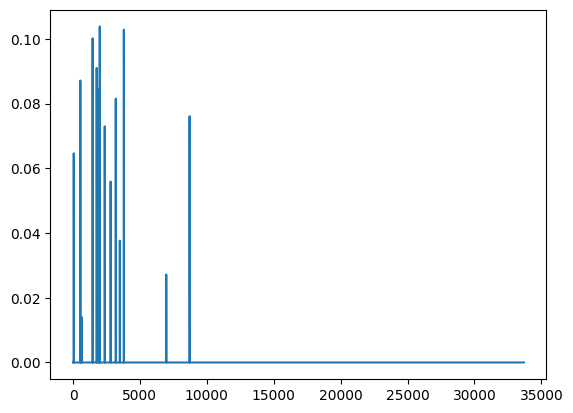

In [256]:
plt.plot(x)

In [223]:
def design_inputs_fw_state(transfer_est, 
        verbose=True, 
        n_iters=1000, 
        k=50, 
        num_random=None,
        cov0=None):
    d = transfer_est.shape[0]
    n = available_idx.shape[0]
    inputs_dist = available_idx.copy() / available_idx.sum()
    #inputs_dist[0] = 1.0
    
    min_inputs = None
    min_loss = 1e10
    loss_vals = []
    A = np.zeros((d,d))
    for i in range(n):
        if available_idx[i] and np.sum(np.isnan(y_session_interp[i,:])) == 0:
            A += np.outer(y_session_interp[i,:], y_session_interp[i,:]) * inputs_dist[i] / (1000*1000)
    
    for iter_idx in range(n_iters):
        max_input = -1
        max_val = 0
        A_inv = la.inv(A + 0.00001 * np.eye(d))
        cov_u = A_inv @ y_session_interp.T / 1000
        ip = np.sum(cov_u * cov_u, axis=0)
        ip = np.multiply(ip,available_idx)
        ip[np.isnan(ip)] = 0
        max_idx = np.argmax(ip)
        gamma = 2/(iter_idx+2)
        A = (1 - gamma) * A + gamma * np.outer(y_session_interp[max_idx,:], y_session_interp[max_idx,:]) / (1000*1000)
        new_dist = np.zeros(n)
        new_dist[max_idx] = 1.0
        inputs_dist = (1 - gamma) * inputs_dist + gamma * new_dist
        
        loss = np.trace(A_inv)
        
        if np.mod(iter_idx,50) == 0 and verbose:
            print(iter_idx,loss)
        loss_vals.append(loss)
    #if verbose:
    plt.plot(loss_vals)
    #plt.yscale('log')
    plt.title("input optimization loss")
    plt.show()
    
    print(loss_vals[0],loss_vals[-1])

    return inputs_dist


# U,S,V = torch.linalg.svd(0.1*torch.randn(663,663))
# S[50:0] = 0
# T = U @ torch.diag(S) @ V

# patterns2 = []
# for i in range(700):
#     patterns2.append(torch.randn(663))
T = B_gt.copy()
state_dist = design_inputs_fw_state(T, n_iters=2000, k=100)
#plt.plot(x)
#print(np.max(x),np.min(x),np.sum(x))

0 2478804.753850775
50 61305790.20916512
100 56339037.383134186
150 51435891.828017585
200 46608899.00619674
250 41883432.34038564
300 37282137.93283622
350 32829444.28728519
400 28586285.70006217
450 24552081.213731382
500 20814437.774545506


KeyboardInterrupt: 

In [250]:
def design_inputs_fw_state2(transfer_est, 
        verbose=True, 
        n_iters=1000, 
        k=50, 
        num_random=None,
        cov0=None):
    d = transfer_est.shape[0]
    n = len(train_segments_y)
    inputs_dist = np.ones(n) / n
    #inputs_dist[0] = 1.0
    
    segments_cov = []
    A = 0.00001 * np.eye(d)
    for i in range(len(train_segments_y)):
        covi = train_segments_y[i][0:15,:].T @ train_segments_y[i][0:15,:] / (1000*1000)
        segments_cov.append(covi)
        A += covi / n
    A_inv = la.inv(A)
#     A_inv_y = []
#     D_y = []
#     for i in range(len(train_segments_y)):
#         A_inv_y.append(A_inv @ train_segments_y[i][0:15,:].T)
#         D_y.append(np.zeros((d,d)))
    min_inputs = None
    min_loss = 1e10
    loss_vals = []
    print(np.trace(A_inv))
    
    for iter_idx in range(n_iters):
        A_inv = la.inv(A)
        A_inv_sq = A_inv @ A_inv
        max_val = -1
        max_idx = -1
        for i in range(len(segments_cov)):
            #val = np.trace(A_inv @ segments_cov[i])
            val = np.trace(train_segments_y[i][0:15,:] @ A_inv_sq @ train_segments_y[i][0:15,:].T)
            if val > max_val:
                max_val = val
                max_idx = i
        gamma = 2/(iter_idx+3)
        A = (1 - gamma) * A + gamma * segments_cov[max_idx].copy()
#        U = train_segments_y[max_idx][0:15,:].copy().T / 1000
#         delta = 1/(1-gamma)
#         D = gamma * (delta**2) * A_inv @ U @ la.inv(np.eye(15) + gamma * delta * U.T @ A_inv @ U) @ U.T @ A_inv
#         print(D.shape)
#         A_inv = delta * A_inv - D
#         print(la.norm(la.inv(A) - A_inv))
#         for i in range(len(segments_cov)):
#             A_inv_y[i] = A_inv @ train_segments_y[i][0:15,:].T
#             D_y[i] = D @ train_segments_y[i][0:15,:].T
        
        new_dist = np.zeros(n)
        new_dist[max_idx] = 1.0
        inputs_dist = (1 - gamma) * inputs_dist + gamma * new_dist
        
        loss = np.trace(A_inv)
        
        if np.mod(iter_idx,5) == 0 and verbose:
            print(iter_idx,loss)
        loss_vals.append(loss)
    #if verbose:
    plt.plot(loss_vals)
    #plt.yscale('log')
    plt.title("input optimization loss")
    plt.show()
    
    print(loss_vals[0],loss_vals[-1])

    return inputs_dist


# U,S,V = torch.linalg.svd(0.1*torch.randn(663,663))
# S[50:0] = 0
# T = U @ torch.diag(S) @ V

# patterns2 = []
# for i in range(700):
#     patterns2.append(torch.randn(663))
T = B_gt.copy()
state_dist = design_inputs_fw_state2(T, n_iters=2000, k=100)
#plt.plot(x)
#print(np.max(x),np.min(x),np.sum(x))

175384.6832493513
0 175384.6832493513
5 3321697.943917485
10 9283594.89713538


KeyboardInterrupt: 

0.111754075 0.0 0.9999999
52


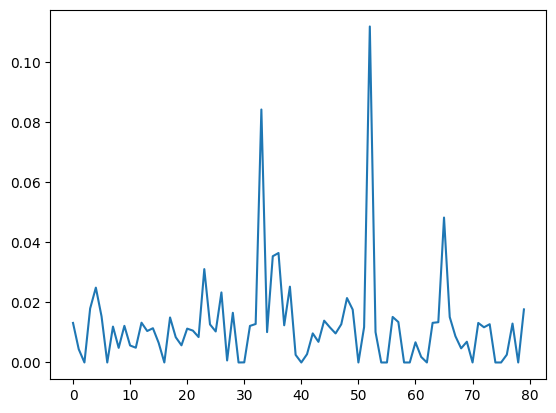

In [270]:
plt.plot(x)
print(np.max(x),np.min(x),np.sum(x))
print(np.random.choice(range(len(x)), p=x))

# OLD: Active Learning

In [ ]:
_,_,V = la.svd(B_gt)
k = 50
V_true = V[0:k,:]
ark_order = 1

e_active_ls = [] #np.zeros(3)
e_active_nuc = [] #np.zeros(3)
e_active_ls_pc1 = [] #np.zeros(3)
e_active_nuc_pc1 = [] #np.zeros(3)
times = [0]
record_interval = 1500

fpr_active = []
tpr_active = []
for i in range(3):
    fpr_active.append(np.zeros(15))
    tpr_active.append(np.zeros(15))

num_trials = 1

for trial_idx in range(num_trials):
    X = []
    X2 = []
    Y = []
    input_cov = 0.000001 * np.eye(k)
    input_full = 0.000001 * np.eye(d)
    x_cov = 0.000001*np.eye(d)
    available_idx = train_indices.copy()
    available_idx[0:5] = 0
    available_idx[-15:] = 0
    e_idx = 0
    count = 0

    #for t in range(u_train.shape[0]):
    for t in range(10001):
        if np.mod(t,2) > 0:
            input_cov_inv = la.inv(input_cov)
            cov_u = input_cov_inv @ V_true @ u_session.T
            ip = np.sum(cov_u * cov_u, axis=0)
            ip = np.multiply(ip,available_idx)
            ip[np.isnan(ip)] = 0
            max_idx = np.argmax(ip)
#             for i in range(len(available_idx)):
#                 if available_idx[i] and np.sum(u_session[i,:]) > 0 and i > 4:
#                     u = V_true @ u_session[i,:]
#                     val = u.T @ input_cov_inv_sq @ u
#                     if val > max_val:
#                         max_val = val
#                         max_idx = i
        else:
#             max_idx = np.random.randint(len(available_idx))
#             while not available_idx[max_idx]:
#                 max_idx = np.random.randint(len(available_idx))
#             input_cov_inv = la.inv(input_full)
#             cov_u = input_cov_inv @ u_session.T
#             ip = np.sum(cov_u * cov_u, axis=0)
#             ip = np.multiply(ip,available_idx)
#             max_idx = np.argmax(ip)

            input_cov_inv = la.inv(x_cov)
            cov_u = input_cov_inv @ y_session_interp.T / 1000
            ip = np.sum(cov_u * cov_u, axis=0)
            ip = np.multiply(ip,available_idx)
            ip[np.isnan(ip)] = 0
            max_idx = np.argmax(ip)

          #  print(np.max(ip))
#             print(np.argmax(ip.flatten()),np.max(ip))
#             plt.plot(ip)
#             plt.show()
#             max_idx = -1
#             max_val = -1
#             input_cov_inv_sq = input_cov_inv @ input_cov_inv
#             for i in range(len(available_idx)):
#                 if available_idx[i]:
#                     u = y_session_interp[i,:].copy().flatten() / 1000
#                     val = u.T @ input_cov_inv_sq @ u
#                     if val > max_val:
#                         max_val = val
#                         max_idx = i
#             print(max_idx)
            
            
#         while max_idx < 5 or max_idx > len(available_idx) - 5:
#             ip[max_idx] = -1
#             max_idx = np.argmax(ip)

        input_cov += np.outer(V_true @ u_session[max_idx,:], V_true @ u_session[max_idx,:])
        input_full += np.outer(u_session[max_idx,:], u_session[max_idx,:])
        for i in range(15):
            offset = 6
            if available_idx[max_idx-offset+i]:
                X.append(np.concatenate((u_session[max_idx-offset+i:max_idx-offset+i+ark_order,:].copy().flatten(), y_session_interp[max_idx-offset+i:max_idx-offset+i+ark_order,:].copy().flatten() / 1000))) 
                X2.append(np.concatenate((u_session[max_idx-offset+i:max_idx-offset+i+ark_order,:].copy().flatten(), y_session_interp[max_idx-offset+i:max_idx-offset+i+ark_order,:].copy().flatten() / 1000, np.ones(1)))) 
                Y.append(y_session_interp[max_idx-offset+i+ark_order,:].copy().flatten() / 1000)
                x = y_session_interp[max_idx-offset+i:max_idx-offset+i+ark_order,:].copy().flatten() / 1000
                x_cov += np.outer(x,x)
                available_idx[max_idx-offset+i] = 0
                count += 1
        #if np.mod(t, record_interval) == 0 and t > 0:
        #if np.mod(count,record_interval) < 15 and count > times[-1] + 15 and t > 0:
        if count > 4500:
            print('estimating')
            print(trial_idx,t,count)
            Xnp = np.array(X)
            X2np = np.array(X2)
            Ynp = np.array(Y)
            A_ls = np.linalg.pinv(X2np.T @ X2np) @ X2np.T @ Ynp
            A_ls = A_ls.T
            A_ls_eval = A_ls.copy()
            A_ls_eval[:,0:d] = A_ls_eval[:,d:2*d]
            A_ls_eval[:,d:2*d] = A_ls[:,0:d]
            # mse = evaluate(A_ls_eval, 1, roc=False)
            mse_active, mse_pc1_active, tpr_active, fpr_active, tpr_noin_active, fpr_noin_active = evaluate(A_ls_eval, 1)
            #mse_active, mse_pc1_active = evaluate(A_ls_eval, 1, roc=False)
            e_active_ls_pc1.append(mse_pc1_active)
            e_active_ls.append(mse_active)
            #e_active_ls[e_idx] += mse / num_trials
            
            A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(Xnp,Ynp,reg=5,transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=0,lr=0.1)
            G_nuc = np.concatenate((A_nuc,B_nuc,v_nuc[:,None]), axis=1)
            mse_active_nuc, mse_pc1_active_nuc, tpr_active_nuc, fpr_active_nuc, tpr_noin_active_nuc, fpr_noin_active_nuc = evaluate(G_nuc, 1)
            #mse_active_nuc, mse_pc1_active_nuc = evaluate(G_nuc, 1, roc=False)
            e_active_nuc_pc1.append(mse_pc1_active_nuc)
            e_active_nuc.append(mse_active_nuc)
            times.append(count)
            
            e_idx += 1
            break
        if count > 10000:
            break
            #break
print('done')

In [ ]:
reg_vals = [1,3,5,7,9]
reg_vals = [50,75]
for reg in reg_vals:
    #A_nuc,B_nuc,v_nuc = est.estimate_gd_nuc_project_AB_offset(Xnp,Ynp,reg=reg,transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=1000,lr=0.1)
    A_nuc,B_nuc,v_nuc = est.estimate_gd_lowrank_AB_offset(Xnp,Ynp,reg=reg,transfer0=[A_ls[:,d:2*d],A_ls[:,0:d],A_ls[:,-1]],n_iters=1000,lr=0.1)
    G_nuc = np.concatenate((A_nuc,B_nuc,v_nuc[:,None]), axis=1)
    mse_active_nuc = evaluate(G_nuc, 1, roc=False)
    print(reg,mse_active_nuc)
mse_active_nuc, tpr_active_nuc, fpr_active_nuc, tpr_noin_active_nuc, fpr_noin_active_nuc = evaluate(G_nuc, 1)  

In [ ]:
mse1, mse1_pc1, tpr1, fpr1, tpr_noin1, fpr_noin1 = evaluate(A_ls2, 1)
plt.figure(figsize=(20,10))
print('mse ls1 ', mse1, 'mse pc1 ls', mse1_pc1)
plt.subplot(1,2,1)
plt.plot(fpr1,tpr1,label='passive ls')
plt.subplot(1,2,2)
plt.plot(fpr_noin1,tpr_noin1,label='passive ls')

print('mse active ', mse_active, 'mse active pc1', mse_pc1_active)
plt.subplot(1,2,1)
plt.plot(fpr_active,tpr_active,label='active ls')
plt.subplot(1,2,2)
plt.plot(fpr_noin_active,tpr_noin_active,label='active ls')

print('mse active nuc ', mse_active_nuc, 'mse active nuc pc1', mse_pc1_active_nuc)
plt.subplot(1,2,1)
plt.plot(fpr_active_nuc,tpr_active_nuc,label='active nuc')
plt.subplot(1,2,2)
plt.plot(fpr_noin_active_nuc,tpr_noin_active_nuc,label='active nuc')

mse_passive_nuc, mse_passive_nuc_pc1, tpr_passive_nuc, fpr_passive_nuc, tpr_noin_passive_nuc, fpr_noin_passive_nuc = evaluate(G_nuc, 1)
print('mse passive nuc ', mse_passive_nuc, 'mse passive nuc pc1 ', mse_passive_nuc_pc1)
plt.subplot(1,2,1)
plt.plot(fpr_passive_nuc,tpr_passive_nuc,label='passive nuc')
plt.subplot(1,2,2)
plt.plot(fpr_noin_passive_nuc,tpr_noin_passive_nuc,label='passive nuc')

plt.subplot(1,2,1)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()

plt.subplot(1,2,2)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()